In [ ]:
import re
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau



from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


plt.style.use('seaborn')
sns.set(font_scale=2.5)
%matplotlib inline

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/fake_news_project/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/fake_news_project/test.csv')
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
train_df.value_counts

<bound method DataFrame.value_counts of           id  ... label
0          0  ...     1
1          1  ...     0
2          2  ...     1
3          3  ...     1
4          4  ...     1
...      ...  ...   ...
20795  20795  ...     0
20796  20796  ...     0
20797  20797  ...     0
20798  20798  ...     1
20799  20799  ...     1

[20800 rows x 5 columns]>

In [ ]:
# Checking the null values in training data.
train_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
train_df=train_df.dropna()

In [ ]:
# Checking the null values in training data.
train_df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [ ]:
# Displaying rows and columns in dataset
print("There are {} number of rows and {} number of columns".format(train_df.shape[0],train_df.shape[1]))

There are 20800 number of rows and 5 number of columns


In [ ]:
print("[title] ",train_df['title'][0])
print("[title] ",train_df['text'][0])

[title]  House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
[title]  House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) 
With apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. 
As we now know, Comey notified the Republican chairmen and Democratic ranking members 

In [ ]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


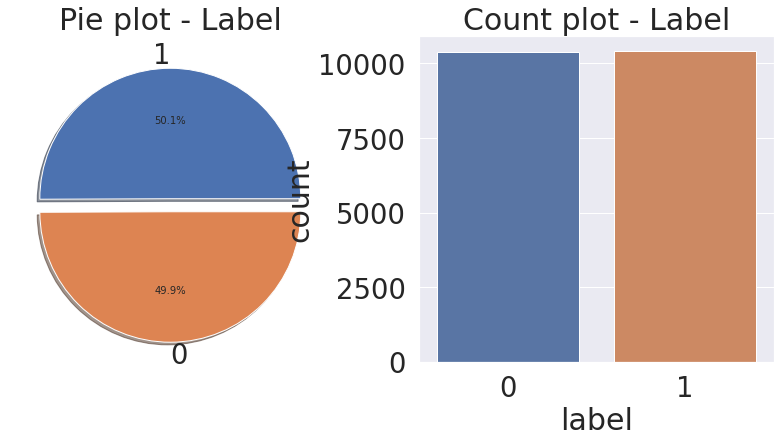

In [ ]:
f,ax = plt.subplots(1,2,figsize=(14,6))
train_df['label'].value_counts().plot.pie(explode=[0, 0.1],autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Label')
ax[0].set_ylabel('')
sns.countplot('label', data = train_df, ax=ax[1])
ax[1].set_title('Count plot - Label')
plt.show()

In [ ]:
def get_length_alphabets(text):
    text = str(text)
    return len(text)

In [ ]:
def get_length_words(text):
    text = str(text)
    return len(text.split(' '))

In [ ]:
train_df['length_alphabets'] = train_df['text'].apply(get_length_alphabets)
train_df['length_words'] = train_df['text'].apply(get_length_words)

In [ ]:
train_df.head()

,id,title,author,text,label,length_alphabets,length_words
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,820
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160,727
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692,1266
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237,559
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938,154


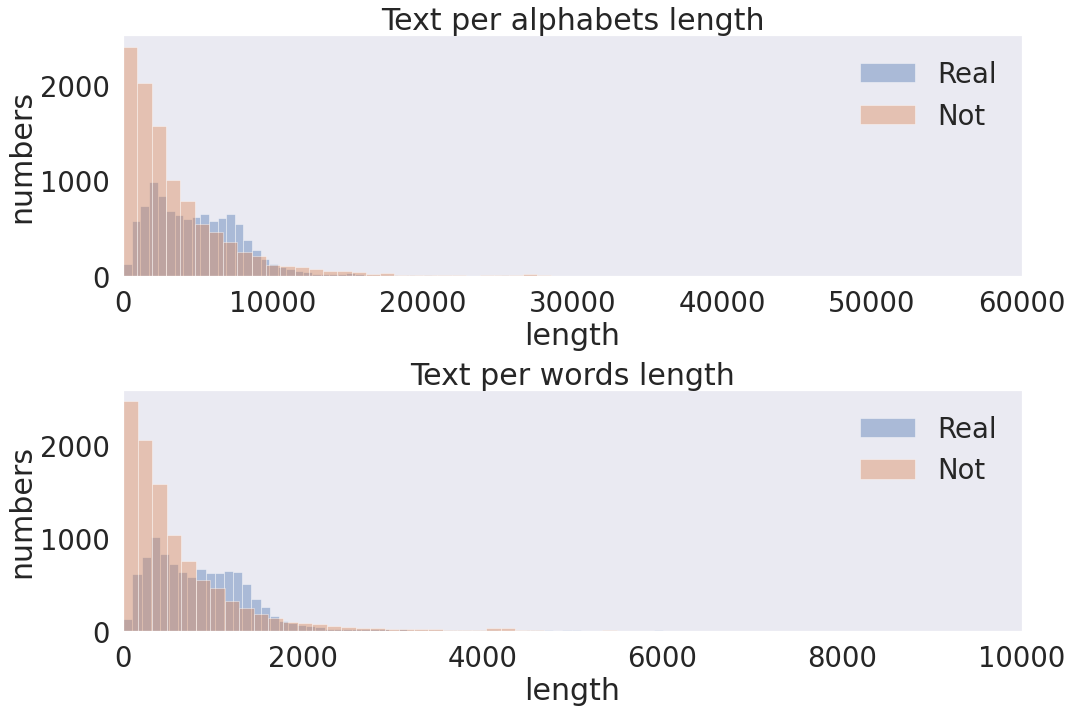

In [ ]:
f, ax = plt.subplots(2,1,figsize=(15,10))

ax[0].set_title('Text per alphabets length')
ax[0].hist(train_df[train_df['label'] == 0]['length_alphabets'], alpha = 0.4, bins=150, label = 'Real')
ax[0].hist(train_df[train_df['label'] == 1]['length_alphabets'], alpha = 0.4, bins=150, label = 'Not')
ax[0].set_xlabel('length')
ax[0].set_ylabel('numbers')
ax[0].legend(loc='upper right')
ax[0].set_xlim(0,60000)
ax[0].grid()

ax[1].set_title('Text per words length')
ax[1].hist(train_df[train_df['label'] == 0]['length_words'], alpha = 0.4, bins=150, label = 'Real')
ax[1].hist(train_df[train_df['label'] == 1]['length_words'], alpha = 0.4, bins=150, label = 'Not')
ax[1].set_xlabel('length')
ax[1].set_ylabel('numbers')
ax[1].legend(loc='upper right')
ax[1].set_xlim(0,10000)
ax[1].grid()

f.tight_layout()
plt.show()

Preporcessing

In [ ]:
train_df[train_df['text'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1,3,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1,3,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1,3,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1,3,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1,3,1


In [ ]:
train_df['text'].fillna("", inplace=True)
test_df['text'].fillna("", inplace=True)

In [ ]:
train_df[train_df['author'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,2729,489
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,8177,1452
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1,2231,377
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1,2801,486
31,31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1,7050,1146


In [ ]:
train_df['author'] = train_df['author'].fillna('unknown')
test_df['author'] = test_df['author'].fillna('unknown')

In [ ]:
train_df[train_df['title'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
53,53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,Sounds like he has our president pegged. What ...,1,679,131
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1,135,16
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1,533,100
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1,736,120
196,196,NaN,Raffie,They got the heater turned up on high.,1,38,8


In [ ]:
# Get average title size
train_df['title_size'] = train_df['title'].apply(lambda x: len(str(x)))

# If title size == 3("NAN") then change title size = 0
train_nan_index = train_df[train_df['title_size']==3].index
train_df['title_size'][train_nan_index] = 0 

train_avg_title_size = int(train_df.value_counts(['title_size']).mean())
print("train avg_title_size: ",train_avg_title_size)

train avg_title_size:  98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Get average title size
test_df['title_size'] = test_df['title'].apply(lambda x: len(str(x)))

# If title size == 3("NAN") then change title size = 0
test_nan_index = test_df[test_df['title_size']==3].index
test_df['title_size'][test_nan_index] = 0 

test_avg_title_size = int(test_df.value_counts(['title_size']).mean())
print("test avg_title_size: ",test_avg_title_size)

test avg_title_size:  33


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#change title "NAN" to text[:98]
train_df['title'][train_nan_index] = train_df['text'][train_nan_index].apply(lambda x: str(x)[:train_avg_title_size])

test_df['title'][test_nan_index] = test_df['text'][test_nan_index].apply(lambda x: str(x)[:test_avg_title_size])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
train_df[train_df['id']==120]

,id,title,author,text,label,length_alphabets,length_words,title_size
120,120,"Same people all the time , i dont know how you...",Anonymous,"Same people all the time , i dont know how you...",1,135,16,0


In [ ]:
train_df.head()

,id,title,author,text,label,length_alphabets,length_words,title_size
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,820,81
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160,727,55
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692,1266,33
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237,559,63
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938,154,93


In [ ]:
train_df.isnull().sum()

id                  0
title               0
author              0
text                0
label               0
length_alphabets    0
length_words        0
title_size          0
dtype: int64

In [ ]:
train_df.drop(['length_alphabets','length_words','title_size'], axis=1, inplace = True)
test_df.drop(['title_size'], axis=1, inplace = True)

In [ ]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
train_df['text']= train_df['author'] + " " + train_df['text']
test_df['text']= test_df['author'] + " " + test_df['text']

In [ ]:
train_df.drop(['id','title','author'], axis=1, inplace=True)
test_df.drop(['id','title','author'], axis=1, inplace=True)

In [ ]:
train_df['text'][0]


'Darrell Lucus House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was 

In [ ]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess(text,stem=False):
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

In [ ]:
nltk.download('wordnet')
train_df['text'] = train_df['text'].apply(lambda x: preprocess(x))
test_df['text'] = test_df['text'].apply(lambda x: preprocess(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
x_train = train_df['text']
y_train = train_df['label']

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size : ",vocab_size)

Vocab size :  225987


In [ ]:
x_train = pad_sequences(
    tokenizer.texts_to_sequences(x_train),
    maxlen = 256)
x_val = pad_sequences(
    tokenizer.texts_to_sequences(x_val),
    maxlen = 256)
x_test = pad_sequences(
    tokenizer.texts_to_sequences(test_df['text']),
    maxlen = 256)

In [ ]:
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_val shape: (4160, 256)
y_val shape: (4160,)


In [ ]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("First Train data squence info : ", x_train[0].shape)
print(x_train[0])

x_train shape: (16640, 256)
y_train shape: (16640,)
First Train data squence info :  (256,)
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0

Training

# LSTM

In [ ]:
inputs = Input(shape=(256,), dtype='int32')

embedding = tf.keras.layers.Embedding(vocab_size, 300)(inputs)
net = SpatialDropout1D(0.2)(embedding)
net = Bidirectional(LSTM(128,dropout=0.2, recurrent_dropout=0.2))(net)
net = Dense(64,activation = 'relu')(net)
net = Dropout(0.3)(net)
net = Dense(1,activation = 'sigmoid')(net)

outputs = net
model = tf.keras.Model(inputs,outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 300)          60974100  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65    

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [ ]:
history = model.fit(
    x_train,
    y_train,
    batch_size=256, 
    epochs=5,
    validation_data=(x_val, y_val)
)

Epoch 1/5
58/58 [==============================] - 174s 3s/step - loss: 0.3442 - accuracy: 0.8366 - val_loss: 0.1323 - val_accuracy: 0.9497
Epoch 2/5
58/58 [==============================] - 167s 3s/step - loss: 0.0460 - accuracy: 0.9860 - val_loss: 0.1746 - val_accuracy: 0.9519
Epoch 3/5
58/58 [==============================] - 168s 3s/step - loss: 0.0163 - accuracy: 0.9952 - val_loss: 0.1657 - val_accuracy: 0.9560
Epoch 4/5
58/58 [==============================] - 165s 3s/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.1693 - val_accuracy: 0.9595
Epoch 5/5
58/58 [==============================] - 166s 3s/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.2163 - val_accuracy: 0.9453


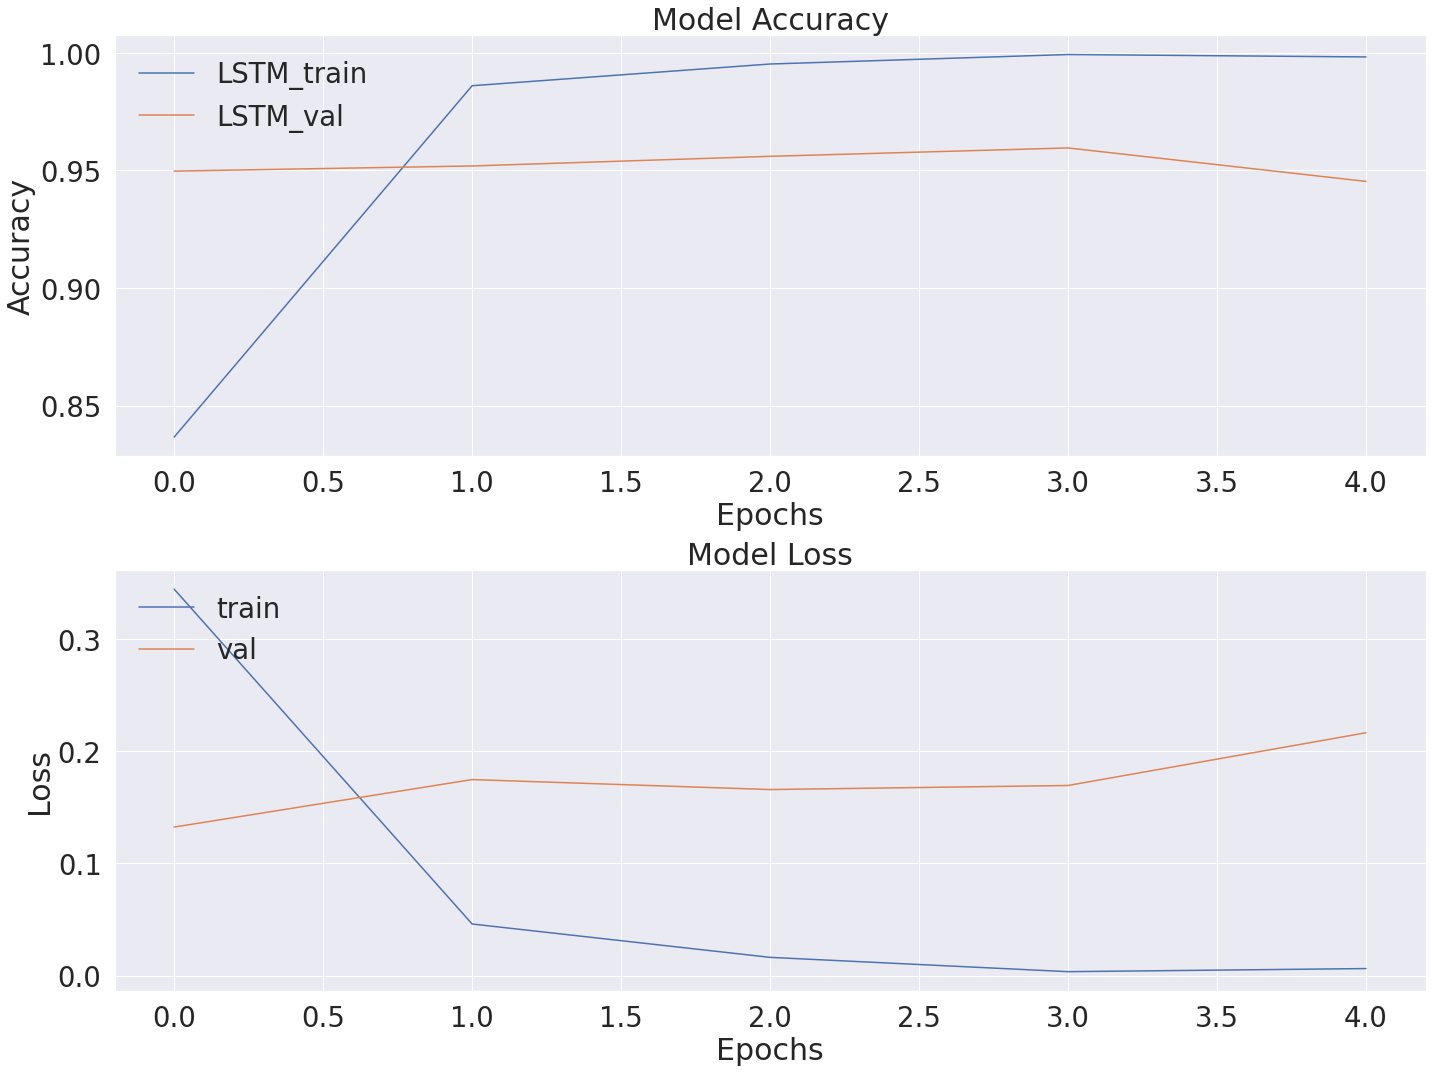

In [ ]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

predict_x=(model.predict(x_val) > 0.5).astype("int32") 

cr1= classification_report(y_val,predict_x)
print(cr1)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2077
           1       0.91      0.97      0.94      1580

    accuracy                           0.95      3657
   macro avg       0.94      0.95      0.94      3657
weighted avg       0.95      0.95      0.95      3657



[[1920  157]
 [  43 1537]]


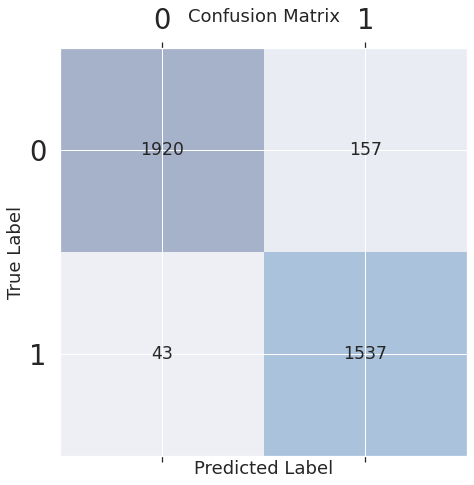

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics


import sklearn.metrics
import numpy

conf_matrix= sklearn.metrics.confusion_matrix(y_val, predict_x)
print(conf_matrix)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Bert

In [ ]:
!pip install --quiet transformers
from transformers import TFBertModel, BertTokenizer

     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 636 kB 44.2 MB/s 
     |████████████████████████████████| 3.3 MB 42.4 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 895 kB 40.8 MB/s 
     |████████████████████████████████| 109 kB 44.6 MB/s 
     |████████████████████████████████| 546 kB 43.9 MB/s 


In [ ]:
#get BERT layer
bert_layers = TFBertModel.from_pretrained('bert-base-uncased')

#get BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [ ]:
encode = bert_tokenizer.encode("Hi nice meet you !")
decode = bert_tokenizer.decode(encode)

print("Encode: ", encode)
print("Decode: ", decode)

Encode:  [101, 7632, 3835, 3113, 2017, 999, 102]
Decode:  [CLS] hi nice meet you! [SEP]


In [ ]:
def bert_encode(data, max_len) :
    input_ids = [] 
    attention_masks = []
    
    for i in range(len(data)):
        encoded = bert_tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
x_train_bert = train_df['text']
y_train_bert = train_df['label']

train_input_ids, train_attention_masks = bert_encode(x_train_bert,60)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = tf.keras.Input(shape=(60,),dtype='int32',name='input_ids')
attention_masks = tf.keras.Input(shape=(60,),dtype='int32',name='attention_masks')

output = bert_layers([input_ids,attention_masks])
output = output[1]
net = tf.keras.layers.Dense(32,activation='relu')(output)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
outputs = net

model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           24608       tf_bert_model[0][1]          

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train_bert,
    validation_split=0.2, 
    epochs=4,
    batch_size=32)

Epoch 1/4
520/520 [==============================] - 445s 835ms/step - loss: 0.1857 - accuracy: 0.9269 - val_loss: 0.0786 - val_accuracy: 0.9709
Epoch 2/4
520/520 [==============================] - 422s 812ms/step - loss: 0.0529 - accuracy: 0.9849 - val_loss: 0.0486 - val_accuracy: 0.9844
Epoch 3/4
520/520 [==============================] - 433s 832ms/step - loss: 0.0263 - accuracy: 0.9928 - val_loss: 0.0481 - val_accuracy: 0.9861
Epoch 4/4
520/520 [==============================] - 425s 817ms/step - loss: 0.0143 - accuracy: 0.9957 - val_loss: 0.0440 - val_accuracy: 0.9870


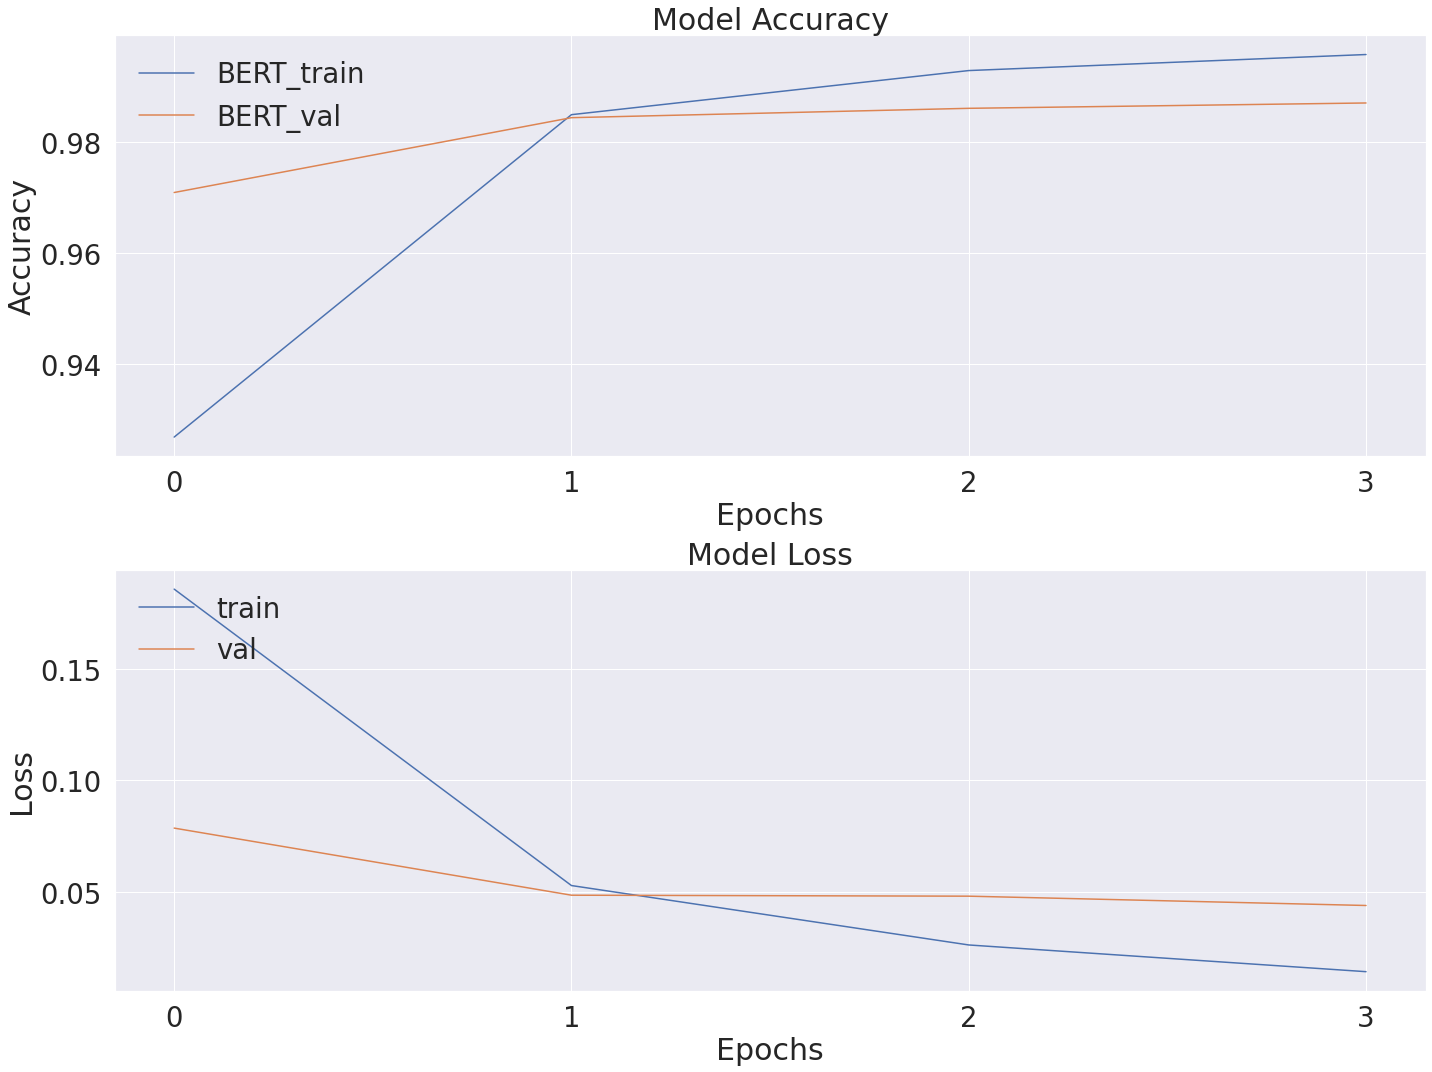

In [ ]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_xticks([0,1,2,3])
ax[0].legend(['BERT_train', 'BERT_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_xticks([0,1,2,3])
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()